In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
X = sorted(glob('data/data/train/image/*.tif'))
Y = sorted(glob('data/data/train/mask/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
print(len(X))

3


In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 300.04it/s]


Split into train and validation datasets.

In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   3
- training:         2
- validation:       1


Training data consists of pairs of input image and label instances.

In [6]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

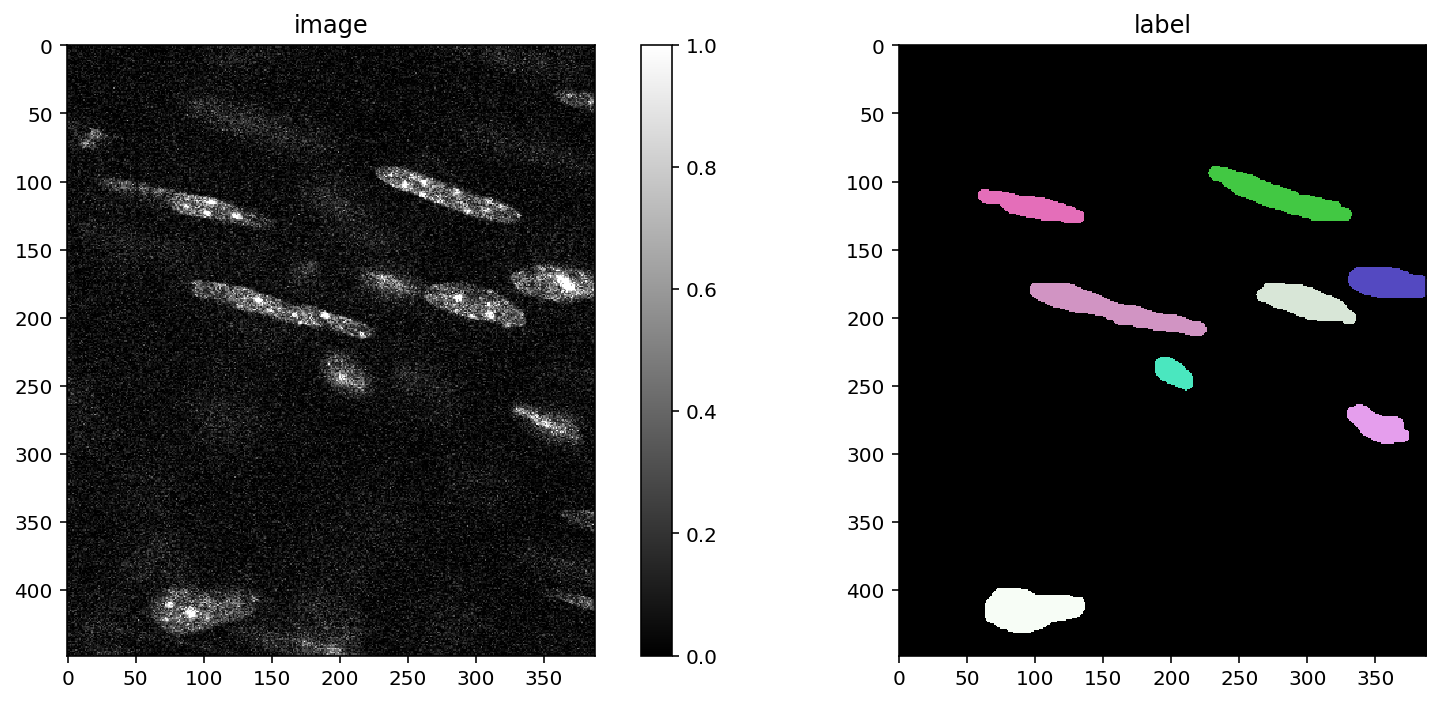

In [7]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [8]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [14]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [15]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    print("use_gpu")

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [16]:
model = StarDist2D(conf, name='stardistGut', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [17]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [41.5 49. ]
network field of view :  [93 94]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [18]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

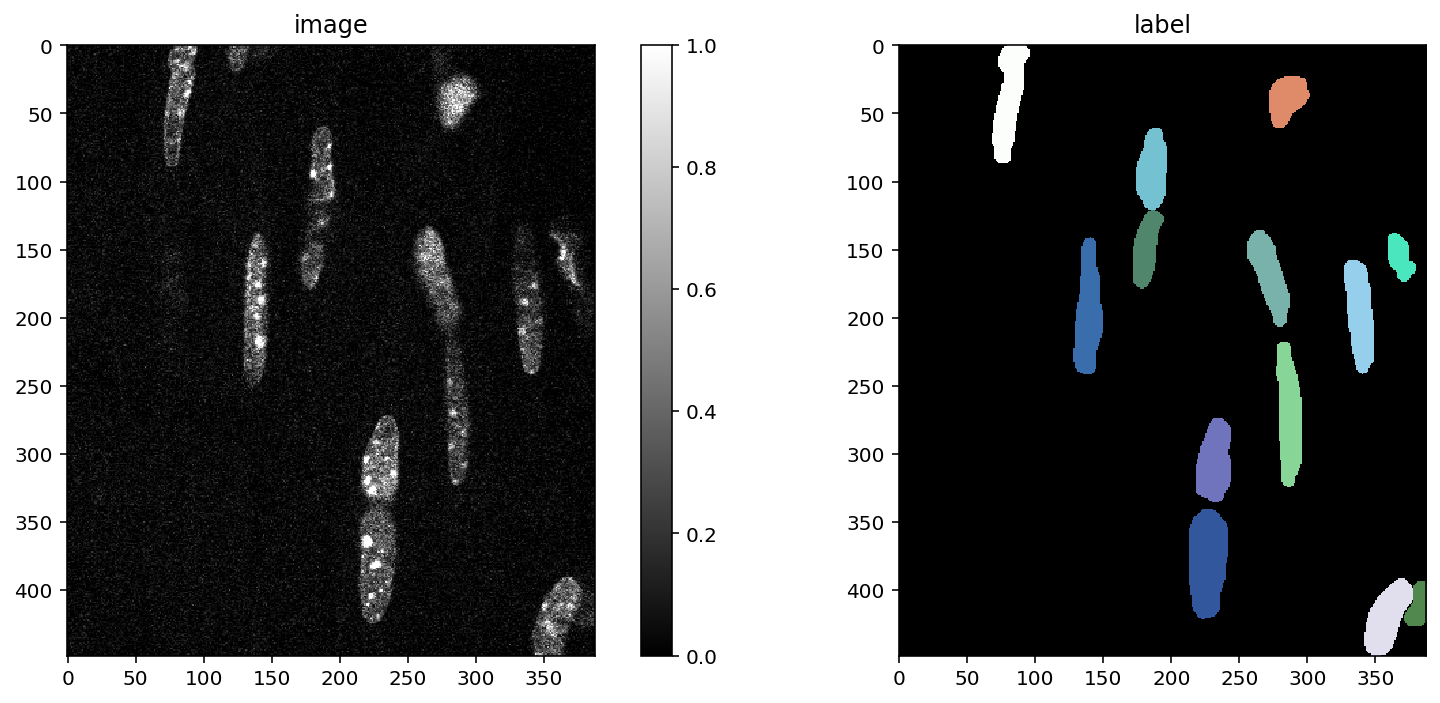

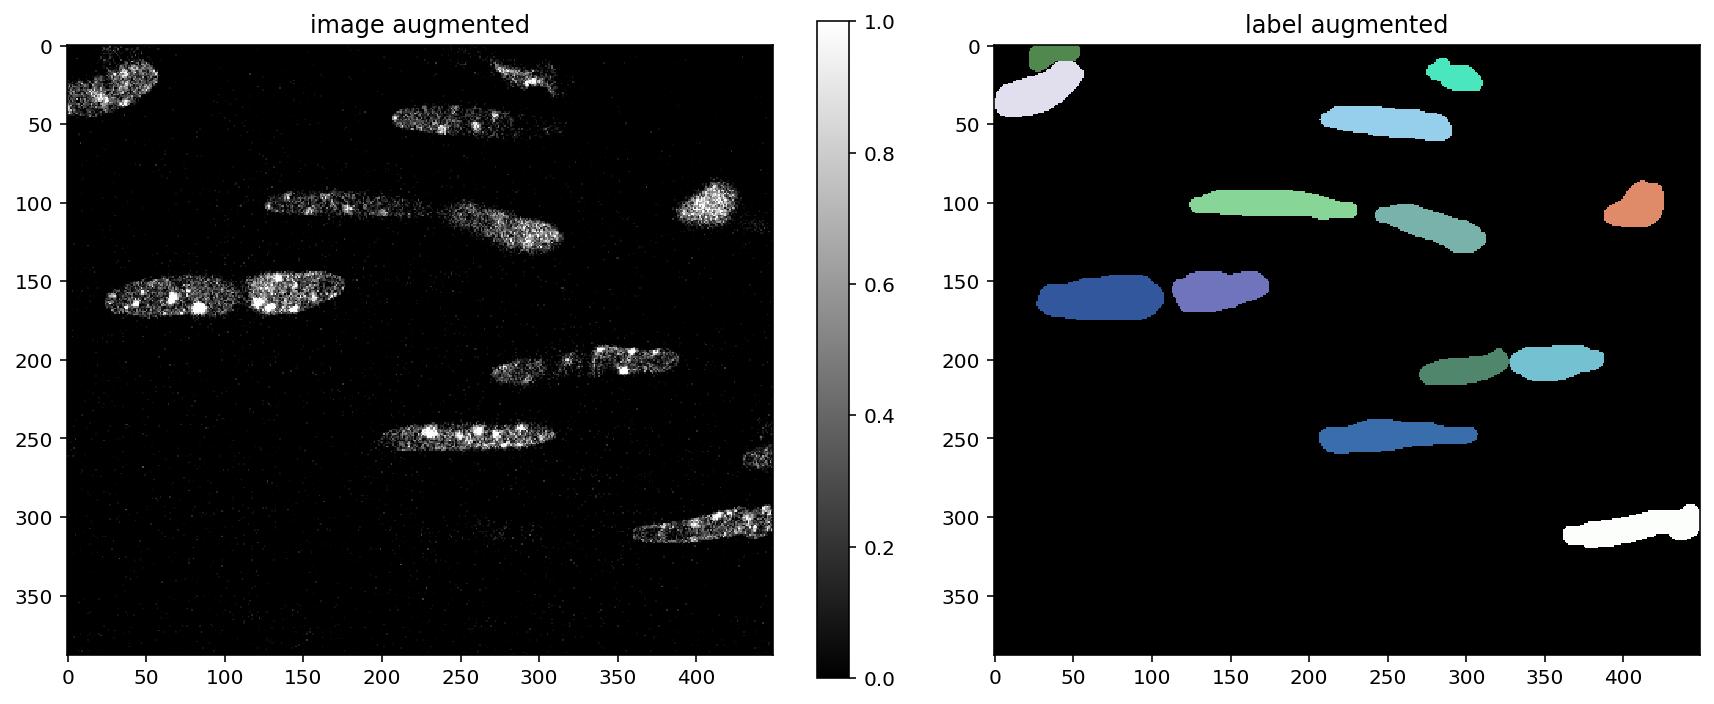

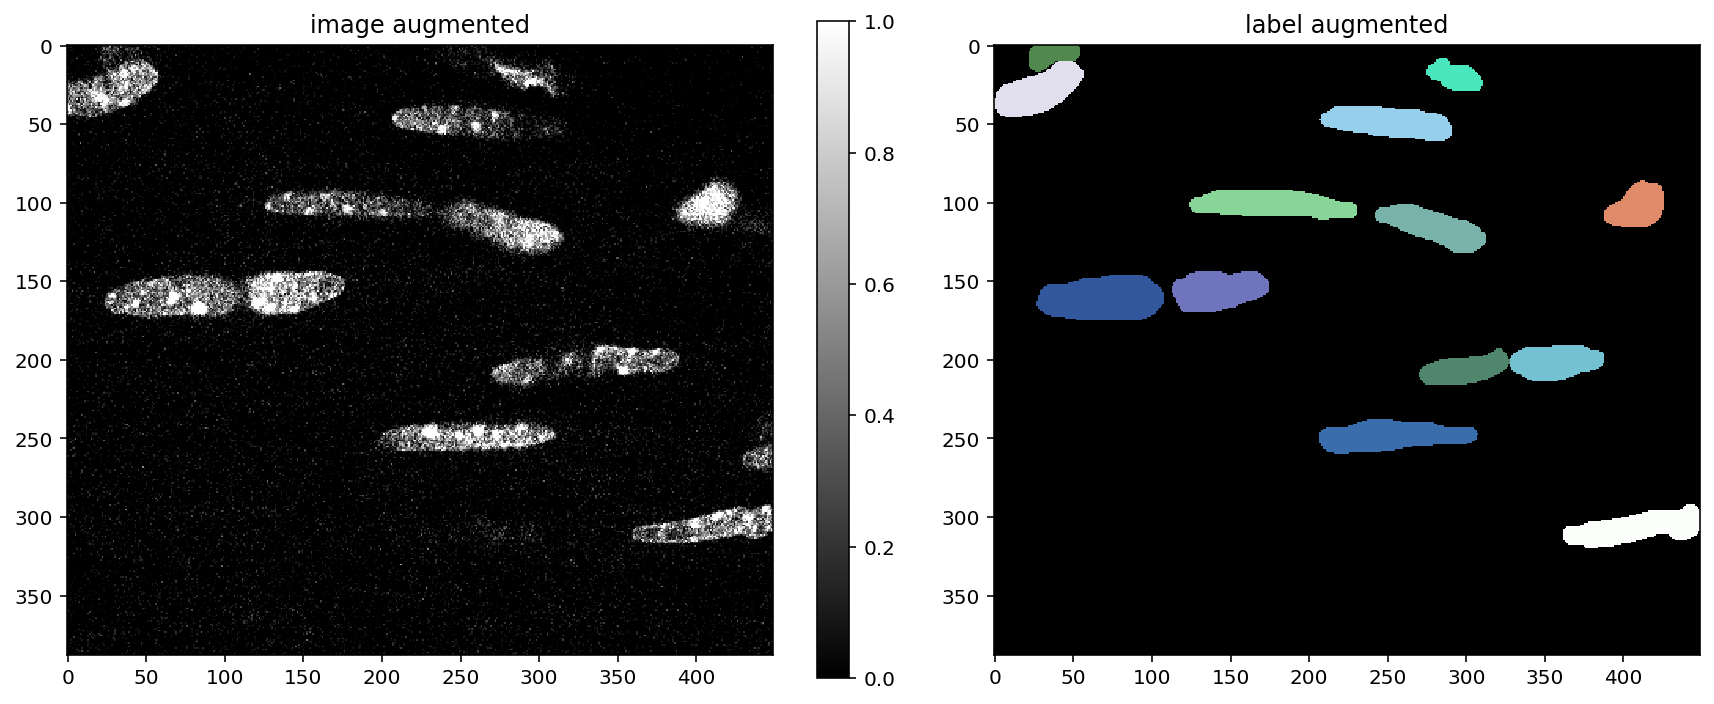

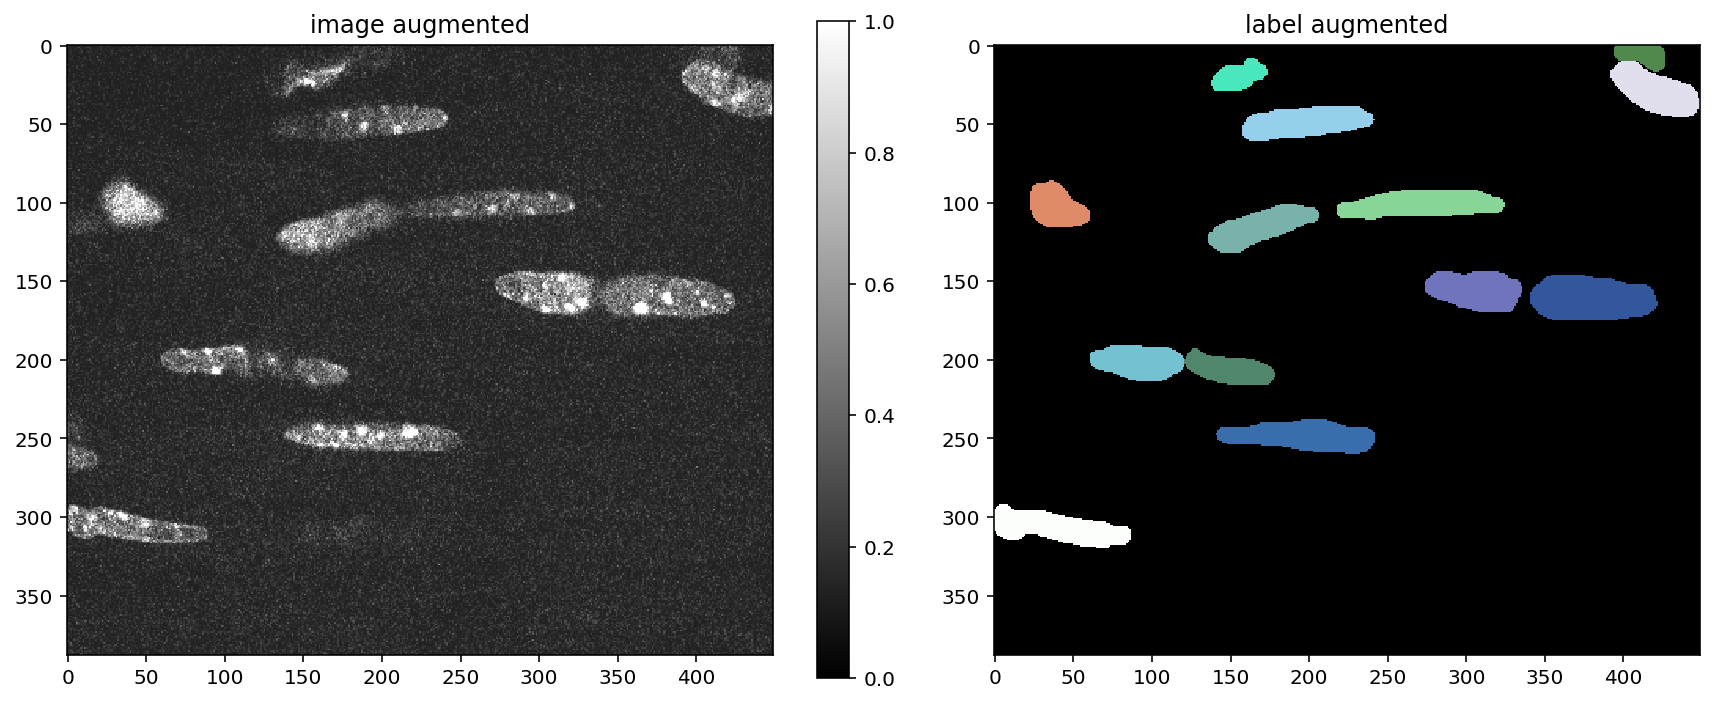

In [19]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

We recommend to monitor the progress during training with [TensorBoard] (Launch it from Anaconda prompt in windows) (https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [20]:




model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)


Epoch 1/400
100/100 [==============================] - 43s 426ms/step - loss: 2.7210 - prob_loss: 0.3615 - dist_loss: 11.7973 - prob_kld: 0.2669 - dist_relevant_mae: 11.7965 - dist_relevant_mse: 251.2904 - val_loss: 2.1272 - val_prob_loss: 0.1242 - val_dist_loss: 10.0150 - val_prob_kld: 0.0919 - val_dist_relevant_mae: 10.0134 - val_dist_relevant_mse: 213.9036 - lr: 3.0000e-04
Epoch 2/400
100/100 [==============================] - 42s 418ms/step - loss: 1.9082 - prob_loss: 0.2586 - dist_loss: 8.2481 - prob_kld: 0.1650 - dist_relevant_mae: 8.2467 - dist_relevant_mse: 134.0771 - val_loss: 1.9917 - val_prob_loss: 0.1307 - val_dist_loss: 9.3046 - val_prob_kld: 0.0984 - val_dist_relevant_mae: 9.3030 - val_dist_relevant_mse: 204.5786 - lr: 3.0000e-04
Epoch 3/400
100/100 [==============================] - 44s 437ms/step - loss: 1.8281 - prob_loss: 0.2076 - dist_loss: 8.1024 - prob_kld: 0.1133 - dist_relevant_mae: 8.1010 - dist_relevant_mse: 131.3787 - val_loss: 1.6763 - val_prob_loss: 0.0801 -

Epoch 23/400
100/100 [==============================] - 47s 472ms/step - loss: 0.4759 - prob_loss: 0.1042 - dist_loss: 1.8582 - prob_kld: 0.0110 - dist_relevant_mae: 1.8576 - dist_relevant_mse: 11.4492 - val_loss: 0.9935 - val_prob_loss: 0.0471 - val_dist_loss: 4.7319 - val_prob_kld: 0.0148 - val_dist_relevant_mae: 4.7314 - val_dist_relevant_mse: 107.2720 - lr: 3.0000e-04
Epoch 24/400
100/100 [==============================] - 47s 473ms/step - loss: 0.4703 - prob_loss: 0.1033 - dist_loss: 1.8352 - prob_kld: 0.0106 - dist_relevant_mae: 1.8346 - dist_relevant_mse: 11.2974 - val_loss: 1.0481 - val_prob_loss: 0.0513 - val_dist_loss: 4.9839 - val_prob_kld: 0.0190 - val_dist_relevant_mae: 4.9834 - val_dist_relevant_mse: 114.6074 - lr: 3.0000e-04
Epoch 25/400
100/100 [==============================] - 52s 521ms/step - loss: 0.4622 - prob_loss: 0.1044 - dist_loss: 1.7888 - prob_kld: 0.0104 - dist_relevant_mae: 1.7883 - dist_relevant_mse: 10.5023 - val_loss: 0.9753 - val_prob_loss: 0.0460 - val

Epoch 45/400
100/100 [==============================] - 50s 502ms/step - loss: 0.3769 - prob_loss: 0.1007 - dist_loss: 1.3812 - prob_kld: 0.0077 - dist_relevant_mae: 1.3807 - dist_relevant_mse: 6.4379 - val_loss: 0.9283 - val_prob_loss: 0.0487 - val_dist_loss: 4.3978 - val_prob_kld: 0.0164 - val_dist_relevant_mae: 4.3974 - val_dist_relevant_mse: 90.5497 - lr: 3.0000e-04
Epoch 46/400
100/100 [==============================] - 50s 499ms/step - loss: 0.3783 - prob_loss: 0.1015 - dist_loss: 1.3838 - prob_kld: 0.0077 - dist_relevant_mae: 1.3832 - dist_relevant_mse: 6.3461 - val_loss: 0.9231 - val_prob_loss: 0.0488 - val_dist_loss: 4.3714 - val_prob_kld: 0.0165 - val_dist_relevant_mae: 4.3710 - val_dist_relevant_mse: 92.9617 - lr: 3.0000e-04
Epoch 47/400
100/100 [==============================] - 51s 514ms/step - loss: 0.3780 - prob_loss: 0.1014 - dist_loss: 1.3830 - prob_kld: 0.0076 - dist_relevant_mae: 1.3825 - dist_relevant_mse: 6.3129 - val_loss: 0.9119 - val_prob_loss: 0.0485 - val_dist

Epoch 67/400
100/100 [==============================] - 51s 507ms/step - loss: 0.3370 - prob_loss: 0.1003 - dist_loss: 1.1832 - prob_kld: 0.0061 - dist_relevant_mae: 1.1828 - dist_relevant_mse: 4.6418 - val_loss: 0.9079 - val_prob_loss: 0.0494 - val_dist_loss: 4.2926 - val_prob_kld: 0.0171 - val_dist_relevant_mae: 4.2923 - val_dist_relevant_mse: 85.9252 - lr: 3.0000e-04
Epoch 68/400
100/100 [==============================] - 48s 477ms/step - loss: 0.3366 - prob_loss: 0.1004 - dist_loss: 1.1812 - prob_kld: 0.0061 - dist_relevant_mae: 1.1807 - dist_relevant_mse: 4.7392 - val_loss: 0.8819 - val_prob_loss: 0.0489 - val_dist_loss: 4.1650 - val_prob_kld: 0.0166 - val_dist_relevant_mae: 4.1647 - val_dist_relevant_mse: 80.9990 - lr: 3.0000e-04
Epoch 69/400
100/100 [==============================] - 49s 489ms/step - loss: 0.3372 - prob_loss: 0.1006 - dist_loss: 1.1832 - prob_kld: 0.0061 - dist_relevant_mae: 1.1827 - dist_relevant_mse: 4.6159 - val_loss: 0.8643 - val_prob_loss: 0.0490 - val_dist

Epoch 89/400
100/100 [==============================] - 45s 450ms/step - loss: 0.3105 - prob_loss: 0.0999 - dist_loss: 1.0531 - prob_kld: 0.0054 - dist_relevant_mae: 1.0527 - dist_relevant_mse: 3.8381 - val_loss: 0.8488 - val_prob_loss: 0.0501 - val_dist_loss: 3.9931 - val_prob_kld: 0.0178 - val_dist_relevant_mae: 3.9929 - val_dist_relevant_mse: 74.9409 - lr: 3.0000e-04
Epoch 90/400
100/100 [==============================] - 45s 446ms/step - loss: 0.3134 - prob_loss: 0.0994 - dist_loss: 1.0700 - prob_kld: 0.0054 - dist_relevant_mae: 1.0696 - dist_relevant_mse: 3.8741 - val_loss: 0.8594 - val_prob_loss: 0.0516 - val_dist_loss: 4.0393 - val_prob_kld: 0.0192 - val_dist_relevant_mae: 4.0390 - val_dist_relevant_mse: 77.3902 - lr: 3.0000e-04
Epoch 91/400
100/100 [==============================] - 50s 495ms/step - loss: 0.3166 - prob_loss: 0.1004 - dist_loss: 1.0809 - prob_kld: 0.0055 - dist_relevant_mae: 1.0805 - dist_relevant_mse: 3.9639 - val_loss: 0.8167 - val_prob_loss: 0.0484 - val_dist

Epoch 111/400
100/100 [==============================] - 46s 460ms/step - loss: 0.3004 - prob_loss: 0.0985 - dist_loss: 1.0095 - prob_kld: 0.0047 - dist_relevant_mae: 1.0091 - dist_relevant_mse: 3.5426 - val_loss: 0.8669 - val_prob_loss: 0.0530 - val_dist_loss: 4.0690 - val_prob_kld: 0.0207 - val_dist_relevant_mae: 4.0688 - val_dist_relevant_mse: 75.6177 - lr: 3.0000e-04
Epoch 112/400
100/100 [==============================] - 44s 444ms/step - loss: 0.3017 - prob_loss: 0.0987 - dist_loss: 1.0150 - prob_kld: 0.0048 - dist_relevant_mae: 1.0146 - dist_relevant_mse: 3.4623 - val_loss: 0.8639 - val_prob_loss: 0.0533 - val_dist_loss: 4.0529 - val_prob_kld: 0.0210 - val_dist_relevant_mae: 4.0526 - val_dist_relevant_mse: 73.4228 - lr: 3.0000e-04
Epoch 113/400
100/100 [==============================] - 45s 452ms/step - loss: 0.3038 - prob_loss: 0.0995 - dist_loss: 1.0212 - prob_kld: 0.0049 - dist_relevant_mae: 1.0208 - dist_relevant_mse: 3.5902 - val_loss: 0.8378 - val_prob_loss: 0.0512 - val_d

Epoch 133/400
100/100 [==============================] - 49s 487ms/step - loss: 0.2870 - prob_loss: 0.0985 - dist_loss: 0.9422 - prob_kld: 0.0044 - dist_relevant_mae: 0.9418 - dist_relevant_mse: 3.2066 - val_loss: 0.8453 - val_prob_loss: 0.0522 - val_dist_loss: 3.9656 - val_prob_kld: 0.0199 - val_dist_relevant_mae: 3.9653 - val_dist_relevant_mse: 72.6609 - lr: 3.0000e-04
Epoch 134/400
100/100 [==============================] - 45s 448ms/step - loss: 0.2940 - prob_loss: 0.0980 - dist_loss: 0.9802 - prob_kld: 0.0044 - dist_relevant_mae: 0.9798 - dist_relevant_mse: 3.2430 - val_loss: 0.8535 - val_prob_loss: 0.0524 - val_dist_loss: 4.0058 - val_prob_kld: 0.0201 - val_dist_relevant_mae: 4.0055 - val_dist_relevant_mse: 73.1199 - lr: 3.0000e-04
Epoch 135/400
100/100 [==============================] - 44s 436ms/step - loss: 0.3035 - prob_loss: 0.0982 - dist_loss: 1.0270 - prob_kld: 0.0048 - dist_relevant_mae: 1.0266 - dist_relevant_mse: 3.4655 - val_loss: 0.8068 - val_prob_loss: 0.0506 - val_d

Epoch 155/400
100/100 [==============================] - 47s 471ms/step - loss: 0.2793 - prob_loss: 0.0982 - dist_loss: 0.9052 - prob_kld: 0.0042 - dist_relevant_mae: 0.9048 - dist_relevant_mse: 2.9300 - val_loss: 0.7811 - val_prob_loss: 0.0502 - val_dist_loss: 3.6546 - val_prob_kld: 0.0179 - val_dist_relevant_mae: 3.6544 - val_dist_relevant_mse: 60.6674 - lr: 3.0000e-04
Epoch 156/400
100/100 [==============================] - 46s 462ms/step - loss: 0.2797 - prob_loss: 0.0987 - dist_loss: 0.9046 - prob_kld: 0.0040 - dist_relevant_mae: 0.9042 - dist_relevant_mse: 2.8683 - val_loss: 0.7677 - val_prob_loss: 0.0486 - val_dist_loss: 3.5952 - val_prob_kld: 0.0163 - val_dist_relevant_mae: 3.5950 - val_dist_relevant_mse: 60.5439 - lr: 3.0000e-04
Epoch 157/400
100/100 [==============================] - 44s 442ms/step - loss: 0.2836 - prob_loss: 0.0978 - dist_loss: 0.9289 - prob_kld: 0.0041 - dist_relevant_mae: 0.9285 - dist_relevant_mse: 3.1011 - val_loss: 0.8081 - val_prob_loss: 0.0518 - val_d

Epoch 177/400
100/100 [==============================] - 46s 456ms/step - loss: 0.2793 - prob_loss: 0.0977 - dist_loss: 0.9077 - prob_kld: 0.0039 - dist_relevant_mae: 0.9073 - dist_relevant_mse: 2.7882 - val_loss: 0.8050 - val_prob_loss: 0.0516 - val_dist_loss: 3.7672 - val_prob_kld: 0.0193 - val_dist_relevant_mae: 3.7670 - val_dist_relevant_mse: 64.4173 - lr: 3.0000e-04
Epoch 178/400
100/100 [==============================] - 51s 511ms/step - loss: 0.2769 - prob_loss: 0.0975 - dist_loss: 0.8969 - prob_kld: 0.0038 - dist_relevant_mae: 0.8965 - dist_relevant_mse: 2.8208 - val_loss: 0.8191 - val_prob_loss: 0.0522 - val_dist_loss: 3.8345 - val_prob_kld: 0.0198 - val_dist_relevant_mae: 3.8343 - val_dist_relevant_mse: 63.8041 - lr: 3.0000e-04
Epoch 179/400
100/100 [==============================] - 51s 513ms/step - loss: 0.2812 - prob_loss: 0.0977 - dist_loss: 0.9175 - prob_kld: 0.0038 - dist_relevant_mae: 0.9171 - dist_relevant_mse: 2.8455 - val_loss: 0.7684 - val_prob_loss: 0.0490 - val_d

Epoch 199/400
100/100 [==============================] - 49s 485ms/step - loss: 0.2713 - prob_loss: 0.0981 - dist_loss: 0.8660 - prob_kld: 0.0037 - dist_relevant_mae: 0.8656 - dist_relevant_mse: 2.6481 - val_loss: 0.7869 - val_prob_loss: 0.0529 - val_dist_loss: 3.6698 - val_prob_kld: 0.0206 - val_dist_relevant_mae: 3.6695 - val_dist_relevant_mse: 60.8823 - lr: 3.0000e-04
Epoch 200/400
100/100 [==============================] - 46s 465ms/step - loss: 0.2669 - prob_loss: 0.0977 - dist_loss: 0.8461 - prob_kld: 0.0036 - dist_relevant_mae: 0.8457 - dist_relevant_mse: 2.5227 - val_loss: 0.7973 - val_prob_loss: 0.0522 - val_dist_loss: 3.7252 - val_prob_kld: 0.0199 - val_dist_relevant_mae: 3.7250 - val_dist_relevant_mse: 62.9994 - lr: 3.0000e-04
Epoch 201/400
100/100 [==============================] - 46s 461ms/step - loss: 0.2749 - prob_loss: 0.0970 - dist_loss: 0.8892 - prob_kld: 0.0037 - dist_relevant_mae: 0.8888 - dist_relevant_mse: 2.6753 - val_loss: 0.8391 - val_prob_loss: 0.0548 - val_d

Epoch 221/400
100/100 [==============================] - 42s 424ms/step - loss: 0.2546 - prob_loss: 0.0974 - dist_loss: 0.7860 - prob_kld: 0.0033 - dist_relevant_mae: 0.7856 - dist_relevant_mse: 2.2827 - val_loss: 0.7856 - val_prob_loss: 0.0521 - val_dist_loss: 3.6671 - val_prob_kld: 0.0198 - val_dist_relevant_mae: 3.6669 - val_dist_relevant_mse: 62.0542 - lr: 1.5000e-04
Epoch 222/400
100/100 [==============================] - 43s 430ms/step - loss: 0.2526 - prob_loss: 0.0982 - dist_loss: 0.7718 - prob_kld: 0.0032 - dist_relevant_mae: 0.7714 - dist_relevant_mse: 2.2100 - val_loss: 0.7861 - val_prob_loss: 0.0525 - val_dist_loss: 3.6681 - val_prob_kld: 0.0201 - val_dist_relevant_mae: 3.6678 - val_dist_relevant_mse: 61.8923 - lr: 1.5000e-04
Epoch 223/400
100/100 [==============================] - 48s 478ms/step - loss: 0.2530 - prob_loss: 0.0982 - dist_loss: 0.7740 - prob_kld: 0.0032 - dist_relevant_mae: 0.7736 - dist_relevant_mse: 2.2347 - val_loss: 0.7745 - val_prob_loss: 0.0515 - val_d

Epoch 243/400
100/100 [==============================] - 46s 457ms/step - loss: 0.2517 - prob_loss: 0.0963 - dist_loss: 0.7770 - prob_kld: 0.0031 - dist_relevant_mae: 0.7766 - dist_relevant_mse: 2.2879 - val_loss: 0.7615 - val_prob_loss: 0.0517 - val_dist_loss: 3.5493 - val_prob_kld: 0.0193 - val_dist_relevant_mae: 3.5490 - val_dist_relevant_mse: 55.3175 - lr: 1.5000e-04
Epoch 244/400
100/100 [==============================] - 49s 488ms/step - loss: 0.2523 - prob_loss: 0.0972 - dist_loss: 0.7757 - prob_kld: 0.0031 - dist_relevant_mae: 0.7753 - dist_relevant_mse: 2.3067 - val_loss: 0.7580 - val_prob_loss: 0.0521 - val_dist_loss: 3.5294 - val_prob_kld: 0.0197 - val_dist_relevant_mae: 3.5291 - val_dist_relevant_mse: 54.8018 - lr: 1.5000e-04
Epoch 245/400
100/100 [==============================] - 46s 456ms/step - loss: 0.2516 - prob_loss: 0.0965 - dist_loss: 0.7753 - prob_kld: 0.0031 - dist_relevant_mae: 0.7750 - dist_relevant_mse: 2.2828 - val_loss: 0.7445 - val_prob_loss: 0.0503 - val_d

Epoch 265/400
100/100 [==============================] - 46s 460ms/step - loss: 0.2476 - prob_loss: 0.0974 - dist_loss: 0.7507 - prob_kld: 0.0030 - dist_relevant_mae: 0.7504 - dist_relevant_mse: 2.1117 - val_loss: 0.7539 - val_prob_loss: 0.0517 - val_dist_loss: 3.5109 - val_prob_kld: 0.0193 - val_dist_relevant_mae: 3.5107 - val_dist_relevant_mse: 54.7990 - lr: 1.5000e-04
Epoch 266/400
100/100 [==============================] - 44s 436ms/step - loss: 0.2477 - prob_loss: 0.0970 - dist_loss: 0.7534 - prob_kld: 0.0029 - dist_relevant_mae: 0.7531 - dist_relevant_mse: 2.1643 - val_loss: 0.7606 - val_prob_loss: 0.0517 - val_dist_loss: 3.5448 - val_prob_kld: 0.0193 - val_dist_relevant_mae: 3.5445 - val_dist_relevant_mse: 55.1760 - lr: 1.5000e-04
Epoch 267/400
100/100 [==============================] - 48s 484ms/step - loss: 0.2485 - prob_loss: 0.0967 - dist_loss: 0.7591 - prob_kld: 0.0030 - dist_relevant_mae: 0.7588 - dist_relevant_mse: 2.1959 - val_loss: 0.7471 - val_prob_loss: 0.0513 - val_d

100/100 [==============================] - 43s 428ms/step - loss: 0.2450 - prob_loss: 0.0963 - dist_loss: 0.7431 - prob_kld: 0.0029 - dist_relevant_mae: 0.7428 - dist_relevant_mse: 2.1241 - val_loss: 0.7443 - val_prob_loss: 0.0510 - val_dist_loss: 3.4664 - val_prob_kld: 0.0186 - val_dist_relevant_mae: 3.4661 - val_dist_relevant_mse: 52.2016 - lr: 1.5000e-04
Epoch 287/400
100/100 [==============================] - 47s 466ms/step - loss: 0.2418 - prob_loss: 0.0948 - dist_loss: 0.7348 - prob_kld: 0.0028 - dist_relevant_mae: 0.7344 - dist_relevant_mse: 2.0791 - val_loss: 0.7421 - val_prob_loss: 0.0511 - val_dist_loss: 3.4554 - val_prob_kld: 0.0186 - val_dist_relevant_mae: 3.4551 - val_dist_relevant_mse: 52.0093 - lr: 1.5000e-04
Epoch 288/400
100/100 [==============================] - 48s 483ms/step - loss: 0.2460 - prob_loss: 0.0980 - dist_loss: 0.7404 - prob_kld: 0.0029 - dist_relevant_mae: 0.7400 - dist_relevant_mse: 2.0865 - val_loss: 0.7599 - val_prob_loss: 0.0523 - val_dist_loss: 3.53

Epoch 308/400
100/100 [==============================] - 59s 592ms/step - loss: 0.2449 - prob_loss: 0.0979 - dist_loss: 0.7350 - prob_kld: 0.0029 - dist_relevant_mae: 0.7346 - dist_relevant_mse: 2.0005 - val_loss: 0.7662 - val_prob_loss: 0.0526 - val_dist_loss: 3.5685 - val_prob_kld: 0.0201 - val_dist_relevant_mae: 3.5682 - val_dist_relevant_mse: 54.6551 - lr: 1.5000e-04
Epoch 309/400
100/100 [==============================] - ETA: 0s - loss: 0.2424 - prob_loss: 0.0970 - dist_loss: 0.7274 - prob_kld: 0.0028 - dist_relevant_mae: 0.7270 - dist_relevant_mse: 2.0155
Epoch 00309: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
100/100 [==============================] - 47s 474ms/step - loss: 0.2424 - prob_loss: 0.0970 - dist_loss: 0.7274 - prob_kld: 0.0028 - dist_relevant_mae: 0.7270 - dist_relevant_mse: 2.0155 - val_loss: 0.7620 - val_prob_loss: 0.0527 - val_dist_loss: 3.5464 - val_prob_kld: 0.0202 - val_dist_relevant_mae: 3.5462 - val_dist_relevant_mse: 54.6090 - lr: 1.

100/100 [==============================] - 44s 438ms/step - loss: 0.2383 - prob_loss: 0.0963 - dist_loss: 0.7101 - prob_kld: 0.0027 - dist_relevant_mae: 0.7097 - dist_relevant_mse: 1.9574 - val_loss: 0.7457 - val_prob_loss: 0.0520 - val_dist_loss: 3.4684 - val_prob_kld: 0.0196 - val_dist_relevant_mae: 3.4682 - val_dist_relevant_mse: 52.0340 - lr: 7.5000e-05
Epoch 330/400
100/100 [==============================] - 45s 452ms/step - loss: 0.2383 - prob_loss: 0.0975 - dist_loss: 0.7042 - prob_kld: 0.0027 - dist_relevant_mae: 0.7038 - dist_relevant_mse: 1.8937 - val_loss: 0.7561 - val_prob_loss: 0.0526 - val_dist_loss: 3.5173 - val_prob_kld: 0.0201 - val_dist_relevant_mae: 3.5171 - val_dist_relevant_mse: 52.3492 - lr: 7.5000e-05
Epoch 331/400
100/100 [==============================] - 44s 439ms/step - loss: 0.2394 - prob_loss: 0.0970 - dist_loss: 0.7121 - prob_kld: 0.0027 - dist_relevant_mae: 0.7118 - dist_relevant_mse: 1.9750 - val_loss: 0.7600 - val_prob_loss: 0.0519 - val_dist_loss: 3.54

100/100 [==============================] - 44s 441ms/step - loss: 0.2360 - prob_loss: 0.0974 - dist_loss: 0.6934 - prob_kld: 0.0026 - dist_relevant_mae: 0.6931 - dist_relevant_mse: 1.8556 - val_loss: 0.7511 - val_prob_loss: 0.0527 - val_dist_loss: 3.4922 - val_prob_kld: 0.0202 - val_dist_relevant_mae: 3.4920 - val_dist_relevant_mse: 51.8322 - lr: 3.7500e-05
Epoch 351/400
100/100 [==============================] - 43s 430ms/step - loss: 0.2357 - prob_loss: 0.0967 - dist_loss: 0.6949 - prob_kld: 0.0026 - dist_relevant_mae: 0.6945 - dist_relevant_mse: 1.8808 - val_loss: 0.7459 - val_prob_loss: 0.0523 - val_dist_loss: 3.4684 - val_prob_kld: 0.0198 - val_dist_relevant_mae: 3.4682 - val_dist_relevant_mse: 51.3623 - lr: 3.7500e-05
Epoch 352/400
100/100 [==============================] - 42s 425ms/step - loss: 0.2363 - prob_loss: 0.0972 - dist_loss: 0.6953 - prob_kld: 0.0026 - dist_relevant_mae: 0.6949 - dist_relevant_mse: 1.8802 - val_loss: 0.7468 - val_prob_loss: 0.0524 - val_dist_loss: 3.47

Epoch 372/400
100/100 [==============================] - 43s 431ms/step - loss: 0.2340 - prob_loss: 0.0964 - dist_loss: 0.6878 - prob_kld: 0.0026 - dist_relevant_mae: 0.6874 - dist_relevant_mse: 1.8285 - val_loss: 0.7411 - val_prob_loss: 0.0519 - val_dist_loss: 3.4459 - val_prob_kld: 0.0194 - val_dist_relevant_mae: 3.4457 - val_dist_relevant_mse: 50.6101 - lr: 3.7500e-05
Epoch 373/400
100/100 [==============================] - 47s 470ms/step - loss: 0.2354 - prob_loss: 0.0967 - dist_loss: 0.6938 - prob_kld: 0.0026 - dist_relevant_mae: 0.6934 - dist_relevant_mse: 1.8913 - val_loss: 0.7502 - val_prob_loss: 0.0524 - val_dist_loss: 3.4894 - val_prob_kld: 0.0199 - val_dist_relevant_mae: 3.4892 - val_dist_relevant_mse: 51.9327 - lr: 3.7500e-05
Epoch 374/400
100/100 [==============================] - 49s 485ms/step - loss: 0.2344 - prob_loss: 0.0969 - dist_loss: 0.6874 - prob_kld: 0.0026 - dist_relevant_mae: 0.6870 - dist_relevant_mse: 1.8235 - val_loss: 0.7441 - val_prob_loss: 0.0524 - val_d

Epoch 394/400
100/100 [==============================] - 48s 482ms/step - loss: 0.2348 - prob_loss: 0.0962 - dist_loss: 0.6927 - prob_kld: 0.0026 - dist_relevant_mae: 0.6924 - dist_relevant_mse: 1.9064 - val_loss: 0.7404 - val_prob_loss: 0.0520 - val_dist_loss: 3.4421 - val_prob_kld: 0.0195 - val_dist_relevant_mae: 3.4419 - val_dist_relevant_mse: 49.9934 - lr: 3.7500e-05
Epoch 395/400
100/100 [==============================] - 50s 501ms/step - loss: 0.2344 - prob_loss: 0.0959 - dist_loss: 0.6925 - prob_kld: 0.0026 - dist_relevant_mae: 0.6921 - dist_relevant_mse: 1.9000 - val_loss: 0.7436 - val_prob_loss: 0.0522 - val_dist_loss: 3.4569 - val_prob_kld: 0.0197 - val_dist_relevant_mae: 3.4567 - val_dist_relevant_mse: 50.5514 - lr: 3.7500e-05
Epoch 396/400
100/100 [==============================] - 48s 477ms/step - loss: 0.2328 - prob_loss: 0.0968 - dist_loss: 0.6801 - prob_kld: 0.0025 - dist_relevant_mae: 0.6798 - dist_relevant_mse: 1.7750 - val_loss: 0.7396 - val_prob_loss: 0.0521 - val_d

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [21]:
  model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  70%|███████████████████████████████▍             | 14/20 [00:00<00:00, 26.82it/s, 0.769 -> 0.569]


Using optimized values: prob_thresh=0.765736, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.7657361186026127, 'nms': 0.3}

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [22]:
# help(matching)

First predict the labels for all validation images:

In [23]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.42it/s]


Plot a GT/prediction example 

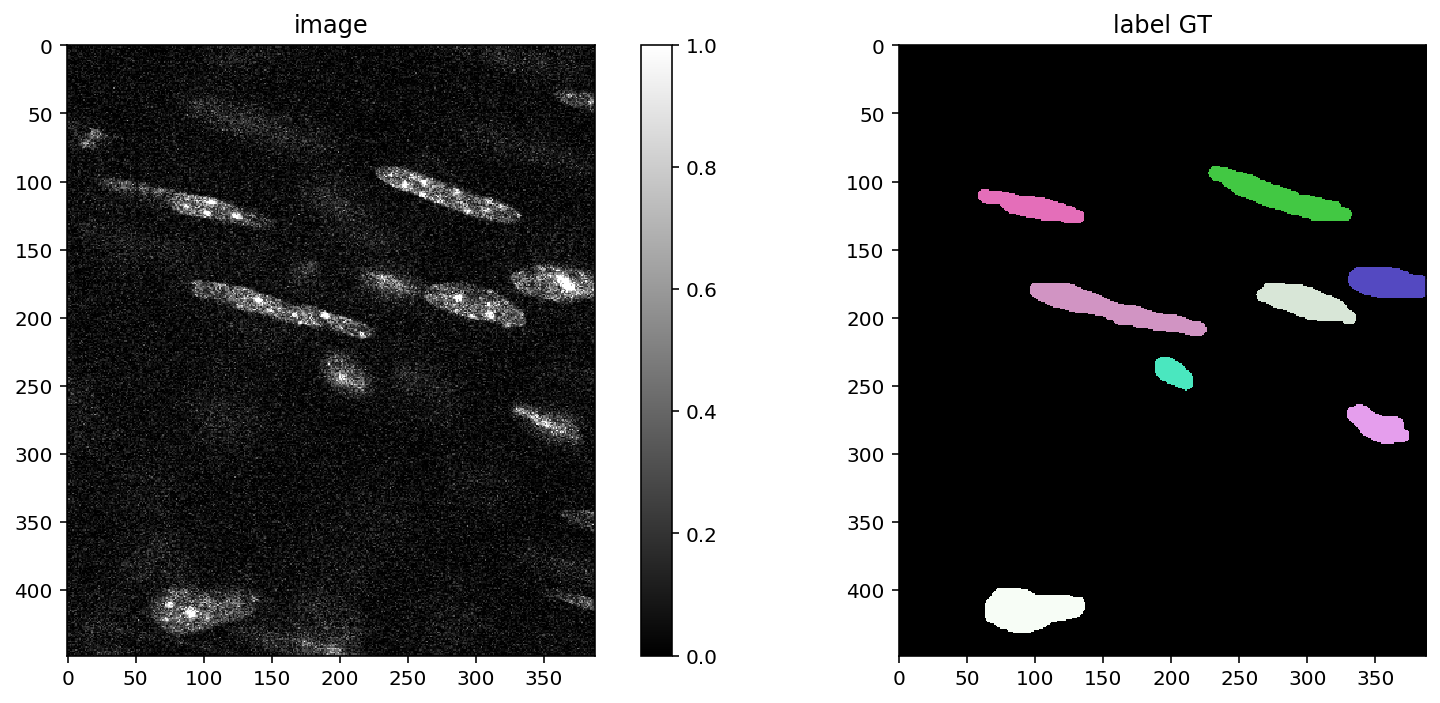

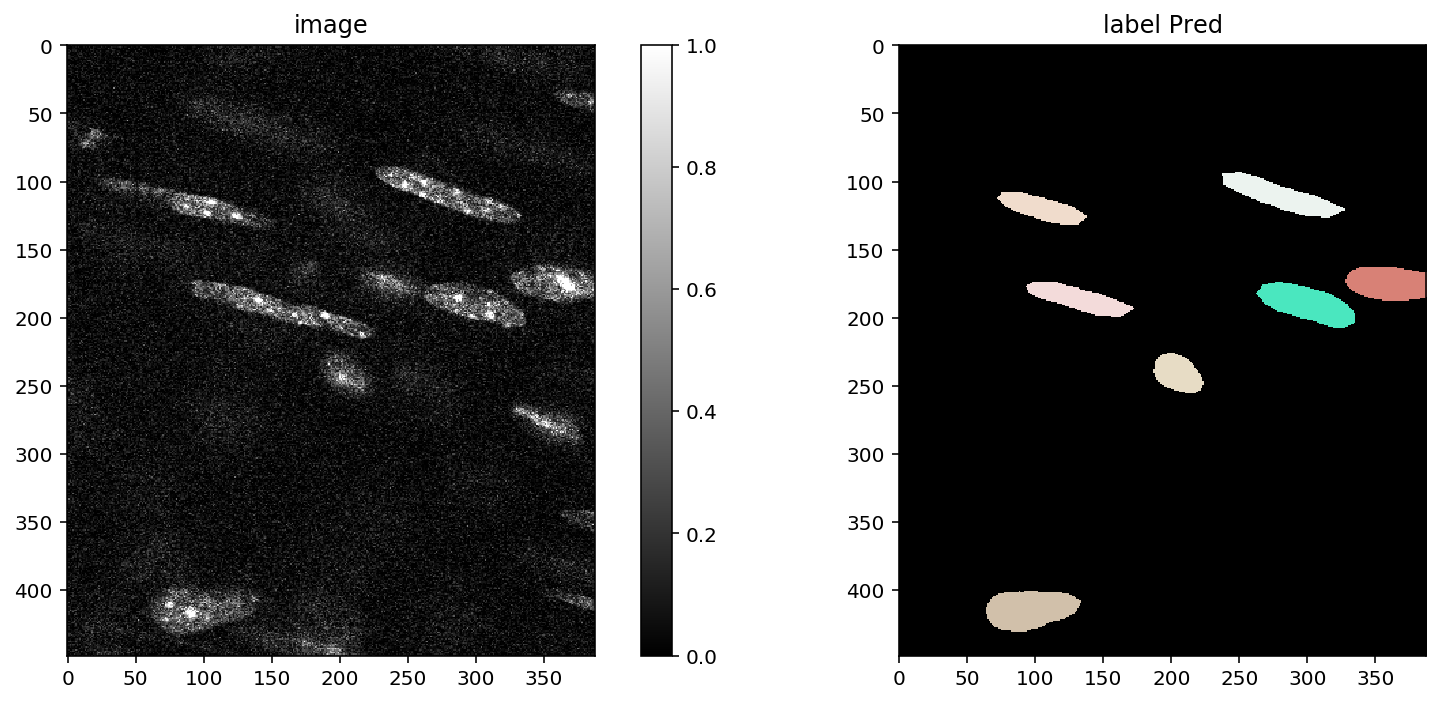

In [24]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [25]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.50it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [26]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=1, tp=6, fn=2, precision=0.8571428571428571, recall=0.75, accuracy=0.6666666666666666, f1=0.8, n_true=8, n_pred=7, mean_true_score=0.5806978006165987, mean_matched_score=0.7742637341554649, panoptic_quality=0.6194109873243719, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

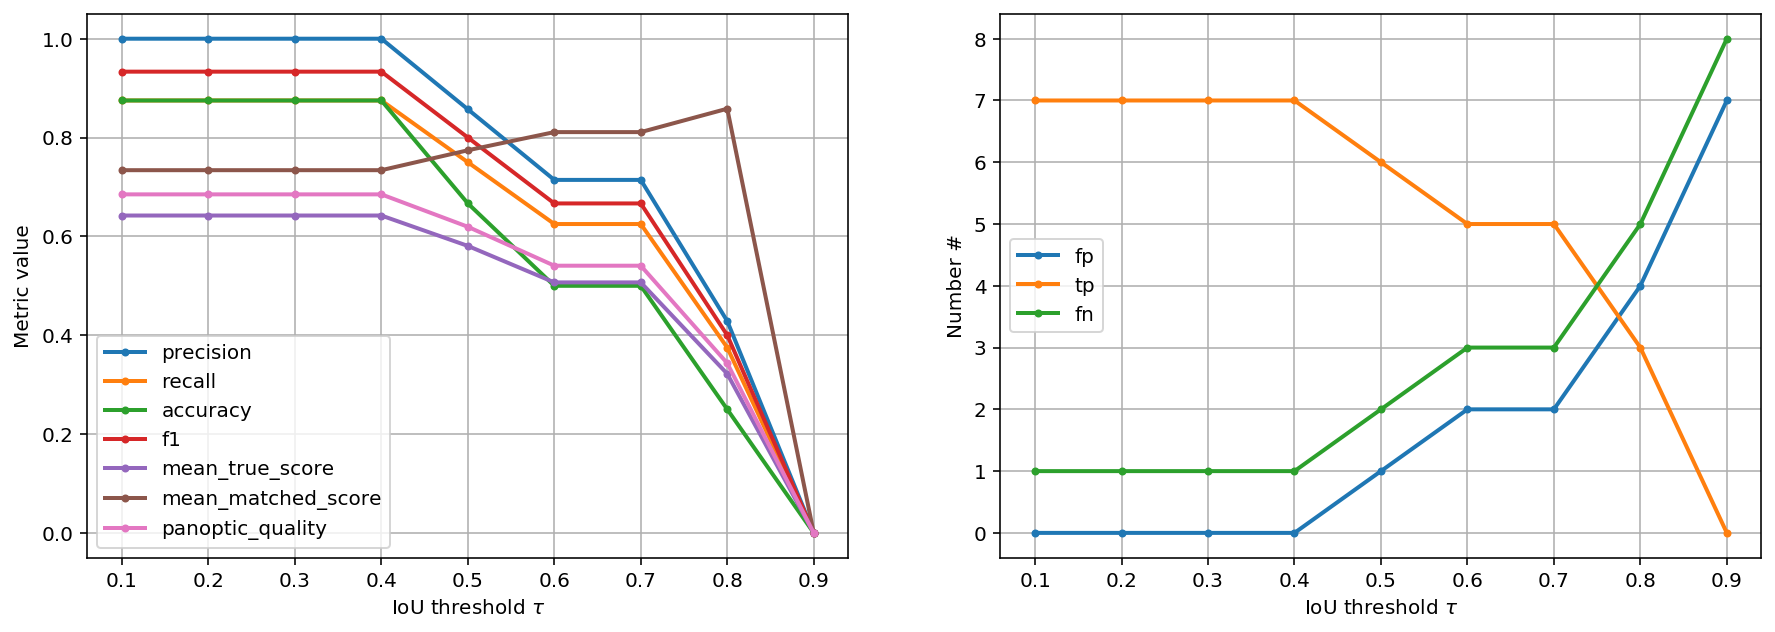

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();